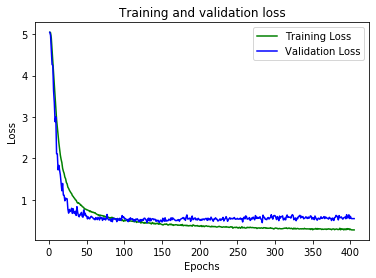

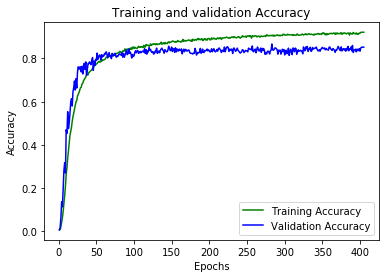

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
# import all libraries
import utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout , SpatialDropout2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import AveragePooling2D, Activation, Input, Add, ZeroPadding2D
from tensorflow.keras.callbacks import History
import numpy as np
import pandas as pd
import os
print(tf.__version__)
import tensorflow.keras as keras
from  tensorflow.keras import optimizers, regularizers, initializers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1_l2, l1,l2
from tensorflow.keras.models import model_from_json
from sklearn.utils import class_weight
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import pyprog
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +
print (tf.config.list_physical_devices('GPU'))


In [2]:
#set the paths and sizes
SETTINGS_DIR = os.path.dirname(os.path.realpath('__file__'))
train_set_path = SETTINGS_DIR+'/images/Control/Train/'
test_set_path = SETTINGS_DIR+"/images/Control/Test/"

dnn_file_name_structure = SETTINGS_DIR +"/cnn_control-new-Resnet1.json"
training_dynamics_path = SETTINGS_DIR+'/TrainingDynamics-new-Resnet1.csv'
dnn_file_name_weights = SETTINGS_DIR +  "/cnn_weight_control-new-Resnet1.h5"

batch_size=128
image_input_size=(150,150)
vocab_size = utilities.get_no_folders_in_path(test_set_path)
print ("Vocabulary Size:",vocab_size)

Vocabulary Size: 155


In [3]:
#make the model
def model_compile(model):
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(hp.Choice('lr', values=[0.01,0.001,0.001])),
                          metrics=['accuracy'])
    
def get_model(hp):


    droprate=hp.Choice('droprate',values=[0.10, 0.15 ,0.25, 0.40, 0.50])
    regularizer=regularizers.l2(hp.Choice('regularizer',values=[1e-2,1e-3,1e-4,1e-5]))
    #droprate2=0.5
    x_input= Input((150,150,3))
    
    x= SeparableConv2D( 
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x_input)    
    x= SpatialDropout2D(droprate)(x)
    x= BatchNormalization()(x)
    x = Activation('relu')(x)
    x= MaxPooling2D (pool_size=(2,2) )(x)
    #classifier.add(Dropout(droprate))
    
    x_shortcut1=x
    x= SeparableConv2D(
        filters=hp.Int('conv_2_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x)
    x= SpatialDropout2D(droprate)(x)    
    x= BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x= SeparableConv2D( 
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x)
    x= SpatialDropout2D(droprate)(x)
    x= BatchNormalization()(x)
    

    x_shortcut1=Convolution2D(filters = x.shape[-1], kernel_size = (1, 1), kernel_regularizer=regularizer)(x_shortcut1)
    x_shortcut1=BatchNormalization()(x_shortcut1)
    
    x = Add()([x, x_shortcut1])
    x = Activation('relu')(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    
    x_shortcut2=x
    x= SeparableConv2D( 
        filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x)
    x= SpatialDropout2D(droprate)(x)    
    x= BatchNormalization()(x)
    x = Activation('relu')(x)
    #classifier.add(Dropout(droprate))
    
    x= SeparableConv2D(
        filters=hp.Int('conv_5_filter', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x) 
    x= SpatialDropout2D(droprate)(x)
    x= BatchNormalization()(x)
    
    x_shortcut2=Convolution2D(filters = x.shape[-1], kernel_size = (1, 1), kernel_regularizer=regularizer)(x_shortcut2)
    x_shortcut2=BatchNormalization()(x_shortcut2)
    x = Add()([x, x_shortcut2])
    x = Activation('relu')(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    
    x_shortcut3=x
    x= SeparableConv2D( 
        filters=hp.Int('conv_6_filter', min_value=64, max_value=256, step=32),
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x)
    x= SpatialDropout2D(droprate)(x)    
    x= BatchNormalization()(x)
    x = Activation('relu')(x)
    #classifier.add(Dropout(droprate))
    
    x= SeparableConv2D(
        filters=hp.Int('conv_7_filter', min_value=64, max_value=384, step=32),
        kernel_size=hp.Choice('conv_7_kernel', values = [3,5]),
        padding='same',
        kernel_regularizer=regularizer)(x) 
    x= SpatialDropout2D(droprate)(x)
    x= BatchNormalization()(x)
    
    x_shortcut3=Convolution2D(filters = x.shape[-1], kernel_size = (1, 1), kernel_regularizer=regularizer)(x_shortcut3)
    x_shortcut3=BatchNormalization()(x_shortcut3)
    x = Add()([x, x_shortcut3])
    x = Activation('relu')(x)
    x= MaxPooling2D(pool_size=(2, 2))(x)
    
    x= Dropout(droprate)(x)    
    x= Flatten( )(x)
    x=Dense (units=vocab_size, kernel_regularizer=regularizer, activation='softmax' )(x)
    
    model = Model(inputs = x_input, outputs = x, name='ResNet-Model')
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(hp.Choice('lr', values=[0.01,0.001,0.001])),
                          metrics=['accuracy'])    
    
    return model

In [4]:
def read_epoch():
    if os.path.exists(training_dynamics_path):
        training_dynamics=pd.read_csv(training_dynamics_path)
        return training_dynamics["Epoch"][len(training_dynamics)-1]
    else:
        return 0

def load_model(learning_rate=0.001):
    # Loading the CNN
    json_file = open(dnn_file_name_structure, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    #print(dnn_file_name_weights)
    model.load_weights(dnn_file_name_weights)
    model_compile(model)
    return model

def save_model(model):
    # Save/overwrite the model
    model_json = model.to_json()
    with open(dnn_file_name_structure, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(dnn_file_name_weights)
# 'acc' is changed to accuracy in new keras
def save_training_dynamics(epoch,history,with_header=False):
    training_dynamics=pd.DataFrame(
        data = [ [epoch, history.history['loss'][0] ,  history.history['accuracy'][0],  
                history.history['val_loss'][0],  history.history['val_accuracy'][0] ]],
        columns=["Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
    )
    if (with_header):
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=True)
    else:
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=False)

In [5]:
#data augmentation
def get_train_test_sets():
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        # https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
        train_datagen = ImageDataGenerator(
                    rescale=1./255,
            width_shift_range=0.30,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=False)
        orig_img=SETTINGS_DIR+"/images/Control/Test/C10/CM06_B1_C10_M3.jpg"
        #generate_plot_pics(train_datagen,orig_img)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # If shuffle=False then the validation results will be different from classifier.predict_generator()
        training_set = train_datagen.flow_from_directory(
            train_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)
        #print(training_set[0])
        test_set = test_datagen.flow_from_directory(
           test_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)
        return training_set, test_set

In [6]:
#traing of the model
def train(ideal_loss=0.01, is_dnn_structure_changned=False,
              learning_rate=0.001,  max_epoch=50, enabled_trasfer_learning=False):
        
        is_new_dnn=False
        history = History()
        
        print("=================================================")
        
        if (os.path.isfile(dnn_file_name_structure) and
                (os.path.isfile(dnn_file_name_weights)) and 
                (is_dnn_structure_changned == False)):
            # load the previosly trained DNN
            if (enabled_trasfer_learning):
                # Enable Transfer Learning
                print ("Transfer learning is enabled.")
                model = FreezeLayers(load_model(),top_unfrozen_layer_name="conv2d_5" ) 
            else:
                print ("Transer learning is disabled.")
                model = load_model(learning_rate=learning_rate)
            print("CNN is loaded.")
        else:
            # Create a new model
            model =  get_model()                    
            print("CNN is created")
            # Erase the training_dynamic_csv file
            if os.path.exists(training_dynamics_path):
                os.remove(training_dynamics_path)
            is_new_dnn=True
            model_compile(model)
        
        ep= read_epoch()+1
        #PringFrozenLayers(model)
        #model.fit_generator instead of model.fit
        history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,
            #steps_per_epoch=500,
                             epochs=1,
                           
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10, 
                             max_queue_size=10)
        save_training_dynamics(ep,history,with_header=is_new_dnn)
       
        while (history.history['loss'][0] >= ideal_loss):
            print("Epoch", ep)
            history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,
            #steps_per_epoch=500,
                             epochs=1,
                             
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10,
                             max_queue_size=10)

            # Save/overwrite the model
            #print('model saved')
            save_model(model)
            
            if (ep%5==0):
                '''
                if(manual_testing()>0.85):
                    break
                '''
            if   (history.history['val_accuracy'][0]>0.88):
                break
                
            ep += 1
            save_training_dynamics(ep,history,with_header=False)        

            # stop the traning if certain training accuracy is reached
            if (history.history['loss'][0]<ideal_loss):
                   break
            if (ep > max_epoch):
                break

        return history

In [7]:
training_set, test_set =get_train_test_sets()

Found 15736 images belonging to 155 classes.
Found 1395 images belonging to 155 classes.


In [27]:
history = train(is_dnn_structure_changned= True, max_epoch=5000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_8 (Separabl (None, 148, 148, 32)      155       
_________________________________________________________________
spatial_dropout2d_8 (Spatial (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 72, 72, 64)        2400      
_________________________________________________________________
spatial_dropout2d_9 (Spatial (None, 72, 72, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 72, 72, 64)       

Epoch 39
122/122 [==============================] - 33s 259ms/step - loss: 0.8126 - accuracy: 0.7703 - val_loss: 0.6923 - val_accuracy: 0.7713
Epoch 40
122/122 [==============================] - 33s 259ms/step - loss: 0.7592 - accuracy: 0.7832 - val_loss: 0.6186 - val_accuracy: 0.7885
Epoch 41
122/122 [==============================] - 32s 256ms/step - loss: 0.7651 - accuracy: 0.7796 - val_loss: 0.6798 - val_accuracy: 0.7778
Epoch 42
122/122 [==============================] - 32s 258ms/step - loss: 0.7481 - accuracy: 0.7836 - val_loss: 0.6705 - val_accuracy: 0.7792
Epoch 43
122/122 [==============================] - 33s 258ms/step - loss: 0.7445 - accuracy: 0.7858 - val_loss: 0.6723 - val_accuracy: 0.7828
Epoch 44
122/122 [==============================] - 32s 257ms/step - loss: 0.7134 - accuracy: 0.7951 - val_loss: 0.7202 - val_accuracy: 0.7620
Epoch 45
122/122 [==============================] - 32s 254ms/step - loss: 0.7059 - accuracy: 0.7947 - val_loss: 0.7462 - val_accuracy: 0.7591

KeyboardInterrupt: 

In [8]:
tuner_search=RandomSearch(get_model,
                          objective='val_accuracy',
                          max_trials=30,directory='tuner_model_Resnet',
                          project_name="dyser_Resnet")

INFO:tensorflow:Reloading Oracle from existing project tuner_model_Resnet/dyser_Resnet/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_model_Resnet/dyser_Resnet/tuner0.json


In [9]:
tuner_search.reload()
model=tuner_search.get_best_models(num_models=1)[0]
best_hps=tuner_search.get_best_hyperparameters(num_trials=1)[0]
print('best hyper parameters are:')
print('droprate',best_hps.get('droprate'))
print('regularizer',best_hps.get('regularizer'))
print('conv_1_filter',best_hps.get('conv_1_filter'))
print('conv_1_kernel',best_hps.get('conv_1_kernel'))
print('conv_2_filter',best_hps.get('conv_2_filter'))
print('conv_2_kernel',best_hps.get('conv_2_kernel'))
print('conv_3_filter',best_hps.get('conv_3_filter'))
print('conv_3_kernel',best_hps.get('conv_3_kernel'))
print('conv_4_filter',best_hps.get('conv_4_filter'))
print('conv_4_kernel',best_hps.get('conv_4_kernel'))
print('conv_5_filter',best_hps.get('conv_5_filter'))
print('conv_5_kernel',best_hps.get('conv_5_kernel'))
print('conv_6_filter',best_hps.get('conv_6_filter'))
print('conv_6_kernel',best_hps.get('conv_6_kernel'))
print('conv_7_filter',best_hps.get('conv_7_filter'))
print('conv_7_kernel',best_hps.get('conv_7_kernel'))
print('lr',best_hps.get('lr'))


best hyper parameters are:
droprate 0.1
regularizer 0.01
conv_1_filter 16
conv_1_kernel 3
conv_2_filter 16
conv_2_kernel 5
conv_3_filter 80
conv_3_kernel 5
conv_4_filter 112
conv_4_kernel 3
conv_5_filter 160
conv_5_kernel 3
conv_6_filter 160
conv_6_kernel 5
conv_7_filter 288
conv_7_kernel 3
lr 0.001


In [10]:
tuner_search.search_space_summary()

Search space summary
Default search space size: 17
droprate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.25, 0.4, 0.5], 'ordered': True}
regularizer (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, '

In [11]:
tuner_search.search(training_set,epochs=40,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )

Trial 8 Complete [00h 38m 43s]
val_accuracy: 0.7749103903770447

Best val_accuracy So Far: 0.8917562961578369
Total elapsed time: 04h 51m 28s
INFO:tensorflow:Oracle triggered exit


In [27]:
model=tuner_search.get_best_models(num_models=2)[1]

In [28]:
model.summary()

Model: "ResNet-Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 150, 150, 48) 267         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 150, 150, 48) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 48) 192         spatial_dropout2d[0][0]          
_______________________________________________________________________________________

In [18]:

tuner_search.search_space_summary()

Search space summary
Default search space size: 13
droprate (Choice)
{'default': 0.15, 'conditions': [], 'values': [0.15, 0.25, 0.4, 0.5, 0.7], 'ordered': True}
regularizer (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 

In [29]:
history=model.fit(training_set,epochs=4,
                    steps_per_epoch=training_set.samples/batch_size,
                    validation_data=test_set,
                    validation_steps=test_set.samples/batch_size,
                    workers=10,
                    max_queue_size=10
                   )

Epoch 1/4
122/122 [==============================] - 66s 511ms/step - loss: 1.2802 - accuracy: 0.8337 - val_loss: 1.1546 - val_accuracy: 0.8638
Epoch 2/4
122/122 [==============================] - 63s 503ms/step - loss: 1.2460 - accuracy: 0.8387 - val_loss: 1.0768 - val_accuracy: 0.8832
Epoch 3/4
122/122 [==============================] - 64s 506ms/step - loss: 1.2763 - accuracy: 0.8306 - val_loss: 1.1824 - val_accuracy: 0.8738
Epoch 4/4
122/122 [==============================] - 64s 508ms/step - loss: 1.2299 - accuracy: 0.8496 - val_loss: 1.1345 - val_accuracy: 0.8609


In [15]:
save_model(model)

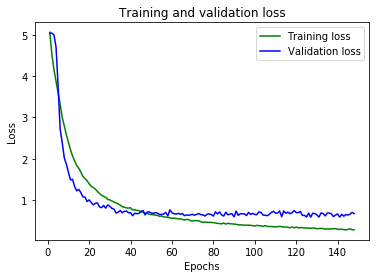

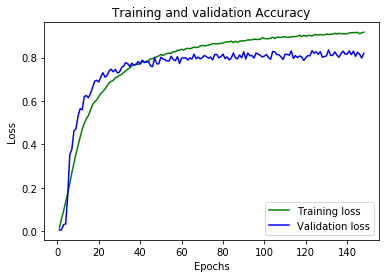

In [29]:
utilities.visualize_training(pd.read_csv(training_dynamics_path))